In [66]:
import os
import numpy as np
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
from torch import nn
from sklearn.decomposition import PCA

from model import BendrEncoder
from model.model import Flatten

from src.data.processing import load_data_dict, get_data
from src.data.conf.eeg_channel_picks import hackathon
from src.data.conf.eeg_channel_order import standard_19_channel
from src.data.conf.eeg_annotations import braincapture_annotations

In [67]:
import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = BendrEncoder()
encoder.load_state_dict(deepcopy(torch.load("encoder.pt", map_location=device)))
encoder = encoder.to(device)

In [69]:
#BC_path = "/mnt/c/Users/anders/Downloads/Bhutan/"
#TUAR_path = "/mnt/c/Users/anders/Downloads/hackathon 01/TUAR/01_tcp_ar/"

data_folder = r'C:/Users/wille/OneDrive - Danmarks Tekniske Universitet/Dokumenter/0. Thesis/trustworthy-causal-ai/data/'

BC_path = data_folder + 'hackathon 01/BC Bhutan/v4.1/'
TUAR_path = data_folder + 'hackathon 01/TUAR/01_tcp_ar/'

annotations = braincapture_annotations

In [70]:
# Check if X_data and y_data are already saved
# If not, load the data and save it

if not os.path.exists("X_data.pt") or not os.path.exists("y_data.pt"):
    data_dict = load_data_dict(BC_path, annotations, labels=True)
    all_subjects = list(data_dict.keys())
    X_data, y_data = get_data(data_dict, all_subjects)
    torch.save(X_data, "X_data.pt")
    torch.save(y_data, "y_data.pt")
else:
    X_data = torch.load("X_data.pt")
    y_data = torch.load("y_data.pt")
    
X_data = X_data.to(device)
y_data = y_data.to(device).long()

In [79]:
def generate_latent_representations(data, encoder, batch_size=5):
    latent_size = (1536, 4)
    latent = np.empty((data.shape[0], *latent_size))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        latent[i:i+batch_size] = encoder(data[i:i+batch_size]).cpu().detach().numpy()

    return latent.reshape((latent.shape[0], -1))

In [80]:
latent_representations = generate_latent_representations(X_data, encoder)

  0%|          | 0/115 [00:00<?, ?it/s]

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

def plot_latent_pca(latent_pca, y_data, annotations, pca, first_index=0, second_index=1):
    fig, ax = plt.subplots(1, 2, figsize=(16, 3))

    # Generate a colormap that has as many colors as you have unique labels
    unique_labels = torch.unique(y_data.cpu())
    n_unique_labels = len(unique_labels)
    cmap = ListedColormap(plt.colormaps.get('tab10').colors[:n_unique_labels])

    # Map each label to a color
    label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

    # Color each point in the scatter plot according to its label
    colors = [label_to_color[label.item()] for label in y_data.cpu()]

    # Plot the scatter plot
    ax[0].scatter(latent_pca[:, first_index], latent_pca[:, second_index], c=colors)
    ax[0].set_xlabel(f"Principal Component {first_index}")
    ax[0].set_ylabel(f"Principal Component {second_index}")
    ax[0].set_title("Latent Space after PCA")

    # Create legend
    legend_labels = [list(annotations.keys())[value] for value in unique_labels]
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=label_to_color[value.item()], markersize=10) for label, value in zip(legend_labels, unique_labels)]
    ax[0].legend(handles=legend_elements)

    # plot the explained variance ratio
    ax[1].plot(pca.explained_variance_ratio_)
    ax[1].set_xlabel("Principal Component")
    ax[1].set_ylabel("Explained Variance Ratio")
    ax[1].set_title("Explained Variance Ratio of Principal Components")

    plt.show()

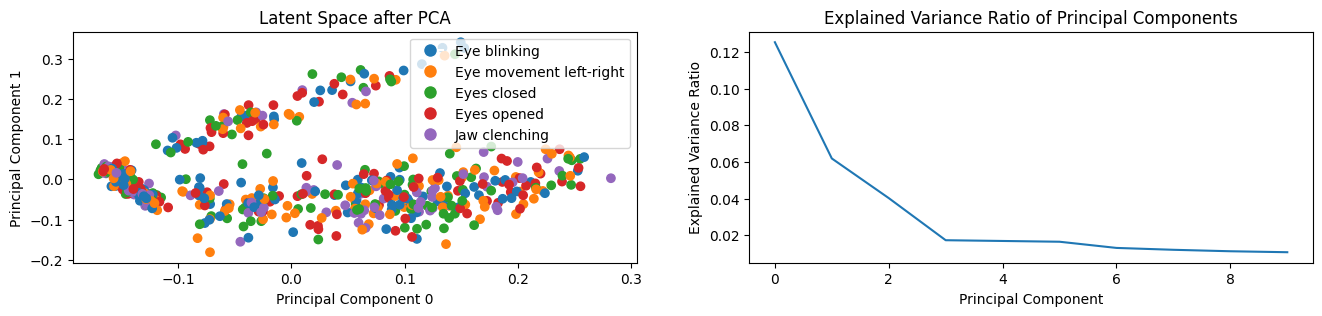

In [81]:
pca = PCA(n_components=10)
latent_pca = pca.fit_transform(latent_representations)

plot_latent_pca(latent_pca, y_data, annotations, pca, first_index=0, second_index=1)

In [48]:
out_features = 5

model = nn.Sequential(
    encoder,
    Flatten(),
    nn.Linear(in_features = 3 * 512 * 4, out_features = 512 * 4, bias=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.ReLU(),
    nn.BatchNorm1d(512 * 4),
    nn.Linear(512 * 4, out_features, bias=True) 
)

model = model.to(device)
model = model.train()

# Lock encoder parameters from training
# for param in model[0].parameters():
#     param.requires_grad = False

In [58]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_data, y_data)

batch_size = 4
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 0.0001
n_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [59]:
for epoch in range(1, n_epochs + 1):
    total = correct = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}, train")
    for batch in train_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model(X)       
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        
        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
        scheduler.step()
        
        pbar.update(1)

    train_accuracy = np.round(100 * correct / total, 2)
    pbar.set_description(f"Epoch {epoch}, train accuracy: {train_accuracy}%")   

Epoch 1, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, train:   0%|          | 0/115 [00:00<?, ?it/s]

In [60]:
with torch.no_grad():
    model.eval()
    total = correct = 0
    pbar = tqdm(total=len(test_loader), desc=f"Testing...")
    for batch in test_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)

        logits = model(X)        
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        pbar.update(1)
        
    pbar.set_description(f"Test accuracy: {100 * correct / total:2f}%")

Testing...:   0%|          | 0/29 [00:00<?, ?it/s]

In [61]:
latent = np.empty((X_data.shape[0], 1536, 4))
batch_size = 4

for i in tqdm(range(0, X_data.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_data[i:i+batch_size].to(device)).cpu().detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

  0%|          | 0/144 [00:00<?, ?it/s]

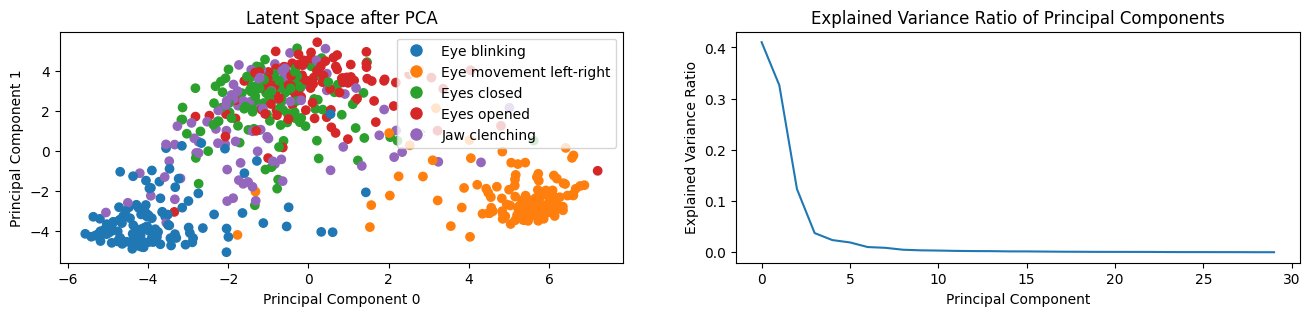

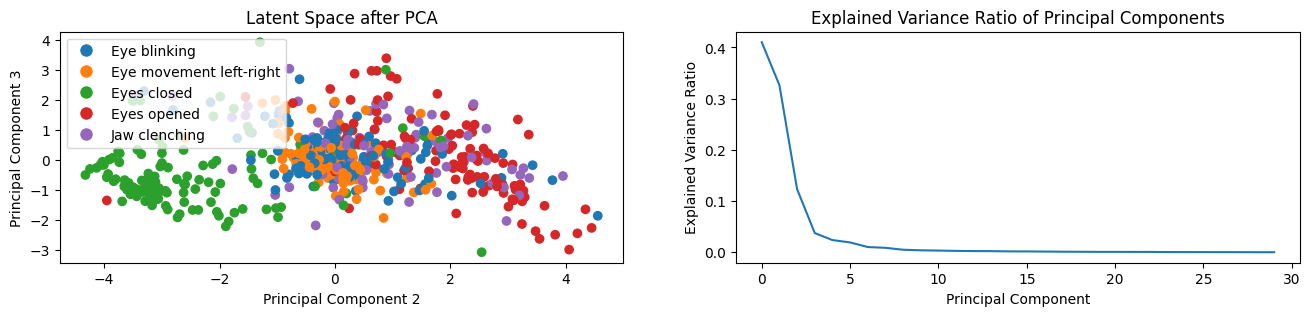

In [65]:
# Run PCA on latent
pca = PCA(n_components=30)
latent_pca = pca.fit_transform(latent)

plot_latent_pca(latent_pca, y_data, annotations, pca, first_index=0, second_index=1)
plot_latent_pca(latent_pca, y_data, annotations, pca, first_index=2, second_index=3)